In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm, multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [3]:
customer_data = pd.read_csv('customer_gmm.csv')
display(customer_data)
customer_data = (np.array(customer_data))[:, 1:]
# print(customer_data)
# print(customer_data.shape)
scaler = StandardScaler()
scaler.fit(customer_data)
customer_data = scaler.transform(customer_data)
# print(customer_data)
# print(customer_data.shape)

,Index,Gender,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,0,67,2,124670,1,2
1,1,1,1,22,1,150773,1,2
2,2,0,0,49,1,89210,0,0
3,3,0,0,45,1,171565,1,1
4,4,0,0,53,1,149031,1,1
...,...,...,...,...,...,...,...,...
1995,1995,1,0,47,1,123525,0,0
1996,1996,1,1,27,1,117744,1,0
1997,1997,0,0,31,0,86400,0,0
1998,1998,1,1,24,1,97968,0,0


# Implementation of Guassian Mixture Models in Python

In [4]:
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.metrics import silhouette_score

class GMM:
    def __init__(self, n_components, iterations=100, threshold=0.004, min_covar=1e-6,seed=64):
        self.n_components = n_components
        self.means_ = None
        self.covariances_ = None
        self.prior_ = None
        self.wij = None
        self.iterations = iterations
        self.threshold = threshold
        self.converged = False
        self.log_likelihood_trace = []
        self.min_covar = min_covar
        self.seed = seed

    def initialize_parameters(self, data):
        n_samples, n_features = data.shape
        self.wij = np.zeros((n_samples, self.n_components))
        np.random.seed(self.seed)
        chosen = np.random.choice(n_samples, self.n_components, replace=False)
        self.means_ = data[chosen]
        self.prior_ = np.full(self.n_components, 1 / self.n_components)
        self.covariances_ = np.tile(np.identity(n_features), (self.n_components, 1, 1))
        return self.means_, self.covariances_, self.prior_

    def fit(self, data):
        means_, covariances_, prior_ = self.initialize_parameters(data)
        log_likelihood = 0
        for _ in range(self.iterations):
            new_log_likelihood = self.expectation_step(data)
            self.maximization_step(data)
            if abs(new_log_likelihood - log_likelihood) <= self.threshold:
                self.converged = True
                break
            log_likelihood = new_log_likelihood
            self.log_likelihood_trace.append(log_likelihood)
        return means_, covariances_, prior_

    def get_parameters(self):
        return self.means_, self.covariances_, self.prior_

    def expectation_step(self, X):
        for component in range(self.n_components):
            self.wij[:, component] = self.prior_[component] * multivariate_normal(self.means_[component], self.covariances_[component]).pdf(X)
        epsilon = 1e-16
        log_likelihood = np.sum(np.log(np.sum(self.wij, axis=1) + epsilon))
        self.wij = self.wij / (self.wij.sum(axis=1, keepdims=1) + epsilon)
        return log_likelihood

    def maximization_step(self, X):
        responsibility_weight_sum = self.wij.sum(axis=0)
        self.prior_ = responsibility_weight_sum / X.shape[0]
        self.means_ = np.dot(self.wij.T, X) / responsibility_weight_sum.reshape(-1, 1)
        for component in range(self.n_components):
            self.covariances_[component] = np.dot(self.wij[:, component] * (X - self.means_[component]).T, (X - self.means_[component])) / responsibility_weight_sum[component]
            self.covariances_[component] += self.min_covar * np.identity(X.shape[1])

    def predict(self):
        return np.argmax(self.wij, axis=1)


64
[-25377.856210011592, -16155.590732523004, -13486.985445197994, -7166.485064197043, -3303.545996153274, 1695.0774674889453, 2992.5919691172717]


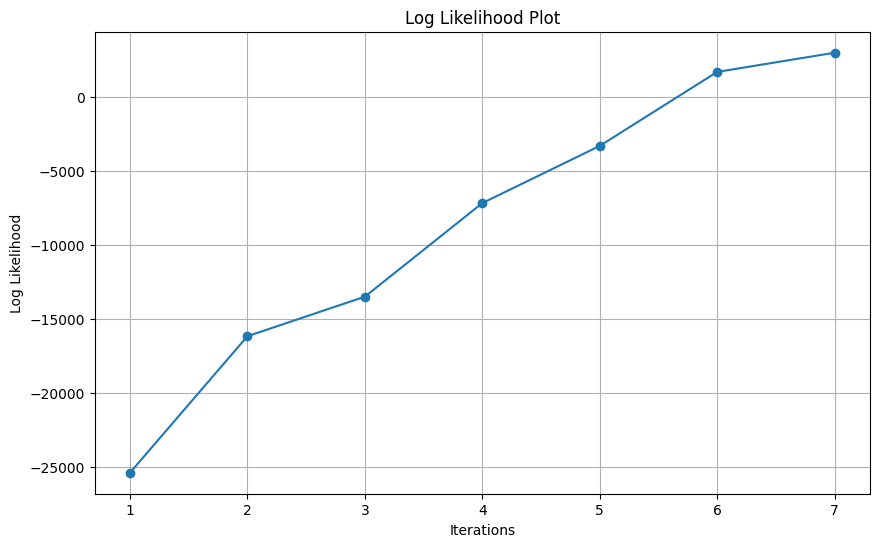

True
Custom GMM Means:
[[-0.91739884 -0.51971628  0.16777833 -0.2246138   0.17902703  0.18576512
   0.27595648]
 [ 1.09003844  1.00702467 -0.23181596  0.37394444 -0.11843403 -0.10753322
  -0.20891344]
 [ 1.09003844 -0.99302433 -0.06511624 -0.17580133 -0.60256172 -0.68874452
  -0.81982299]]
Scikit-learn GMM Means:
[[-0.91739884 -0.51971623  0.1677783  -0.22461369  0.1790271   0.18576517
   0.27595652]
 [ 1.09003844  1.00702467 -0.23181596  0.37394444 -0.11843403 -0.10753322
  -0.20891344]
 [ 1.09003844 -0.99302433 -0.06511624 -0.17580133 -0.60256172 -0.68874452
  -0.81982299]]

Custom GMM Covariances:
[[[ 1.00000000e-06 -4.99931534e-29 -4.64890418e-32  1.10411474e-30
   -4.78837131e-30  1.85956167e-29 -9.69296522e-30]
  [-5.04057436e-29  7.22619785e-01 -1.57785782e-01  2.88238934e-01
   -5.96119615e-02  3.52477108e-03 -2.61494293e-02]
  [ 9.29780837e-32 -1.57785782e-01  9.70725300e-01  7.21761039e-01
    3.23408414e-01  9.68014475e-02  8.45567421e-02]
  [ 1.20871509e-30  2.88238934e-01 

In [24]:
gmm = GMM(n_components = 3,seed=64)
# print(seed)
means_,covariances_,prior_ = gmm.fit(customer_data)
print(gmm.log_likelihood_trace)
plt.figure(figsize=(10, 6))
plt.plot(range(1,len(gmm.log_likelihood_trace)+1), gmm.log_likelihood_trace, marker='o', linestyle='-')
plt.xlabel('Iterations')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood Plot')
plt.grid(True)
plt.show()
sklearn_gmm = GaussianMixture(n_components=gmm.n_components, covariance_type='full', tol=gmm.threshold,means_init=means_,precisions_init=covariances_,weights_init=prior_)
sklearn_gmm.fit(customer_data)
print(gmm.converged)
# Compare the results
print("Custom GMM Means:")
print(gmm.means_)
print("Scikit-learn GMM Means:")
print(sklearn_gmm.means_)

print("\nCustom GMM Covariances:")
print(gmm.covariances_)
print("Scikit-learn GMM Covariances:")
print(sklearn_gmm.covariances_)

print("\nCustom GMM Priors:")
print(gmm.prior_)
print("Scikit-learn GMM Priors:")
print(sklearn_gmm.weights_)

# GMM on Wine Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

# Load the wine dataset
wine_data = load_wine()
X = wine_data.data
y = wine_data.target
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

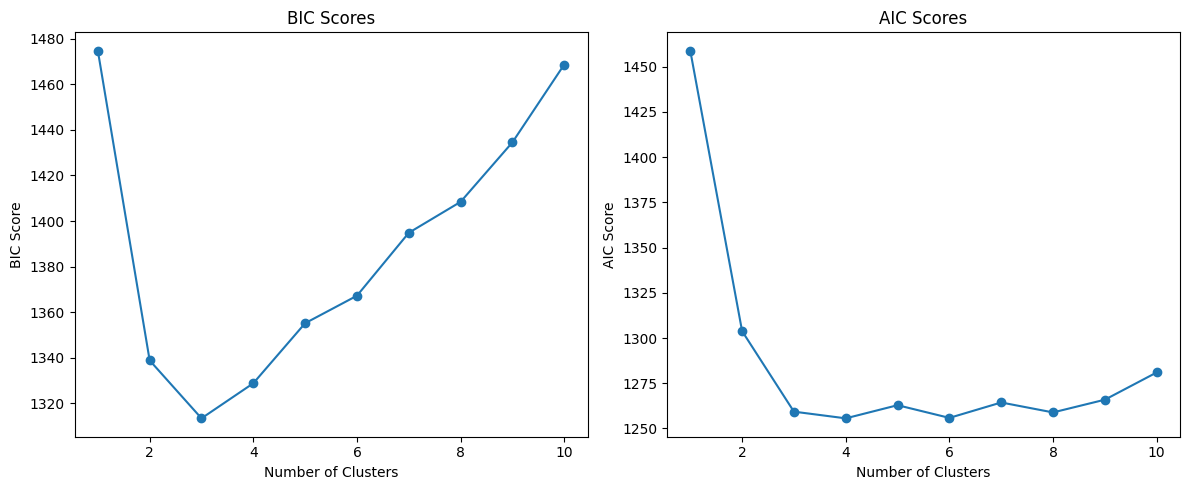

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

# Load the wine dataset
wine_data = load_wine()
X = wine_data.data
y = wine_data.target

# Standardize the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Find the optimal number of clusters for GMM using BIC and AIC
n_components_range = range(1, 11)
bic_scores = []
aic_scores = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(X_pca)
    bic_scores.append(gmm.bic(X_pca))
    aic_scores.append(gmm.aic(X_pca))

# Plot AIC and BIC scores
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(n_components_range, bic_scores, marker='o')
plt.title('BIC Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC Score')

plt.subplot(1, 2, 2)
plt.plot(n_components_range, aic_scores, marker='o')
plt.title('AIC Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('AIC Score')

plt.tight_layout()
plt.show()


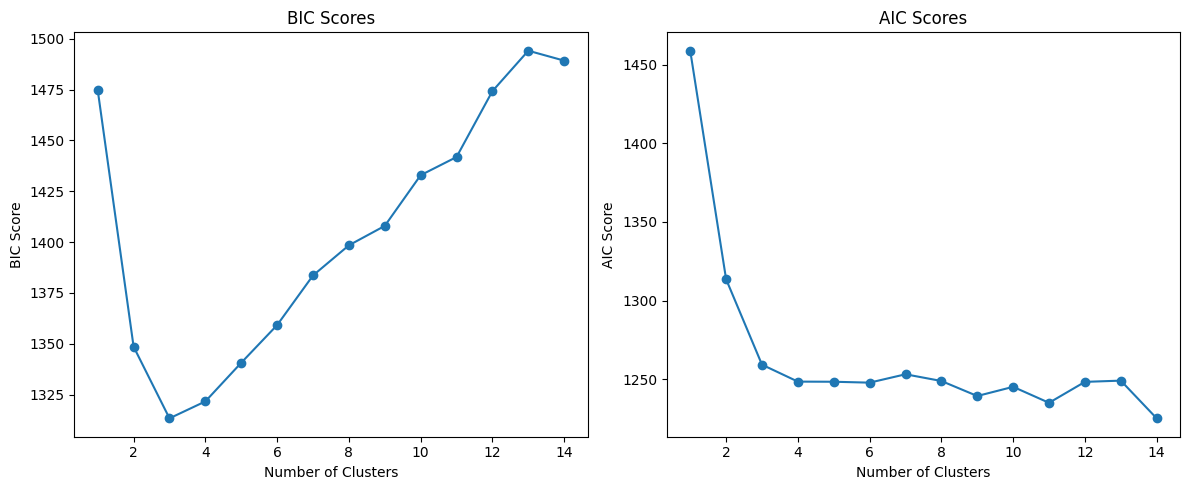

In [45]:
def calculate_aic_bic(data, n_clusters):
    gmm = GMM(n_components=n_clusters)
    gmm.fit(data)
    log_likelihood = gmm.log_likelihood_trace[-1]
    num_params = n_clusters * (data.shape[1] + 1) * (data.shape[1] + 2) / 2 - 1  # Corrected formula
    aic = 2 * num_params - 2 * log_likelihood
    bic = np.log(data.shape[0]) * num_params - 2 * log_likelihood
    return aic, bic

bic_scores = []
aic_scores = []
n_components_range = range(1, 15)  # Define the range of components

for components in n_components_range:
    aic, bic = calculate_aic_bic(X_pca, components)
    bic_scores.append(bic)
    aic_scores.append(aic)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(n_components_range, bic_scores, marker='o')
plt.title('BIC Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC Score')

plt.subplot(1, 2, 2)
plt.plot(n_components_range, aic_scores, marker='o')
plt.title('AIC Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('AIC Score')

plt.tight_layout()
plt.show()


/home/rohit172/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


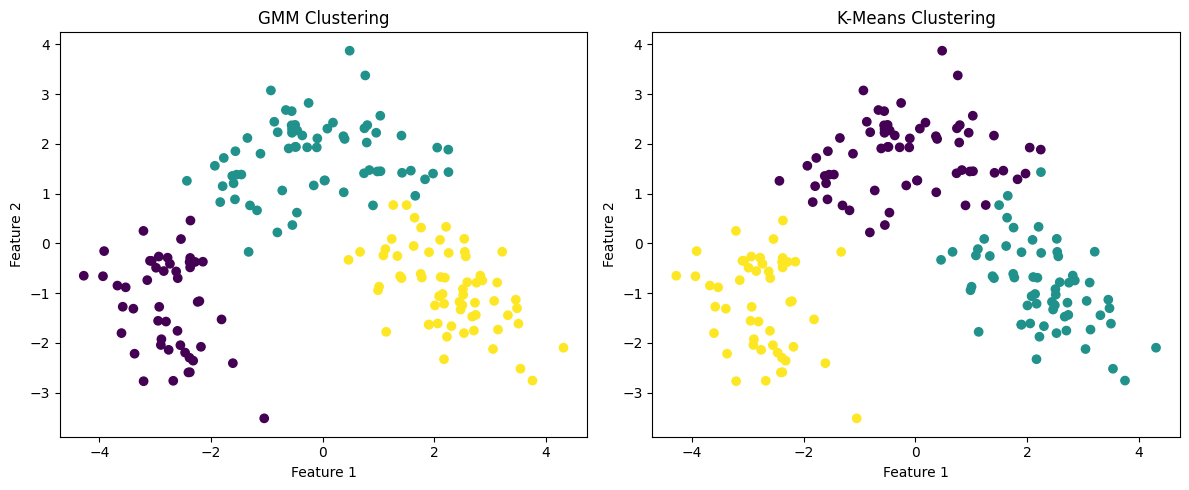

/tmp/ipykernel_11671/3376291371.py:20: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(x_grid, y_grid, z_grid, colors=col[i], label=f'Component {i + 1}', alpha=0.7)


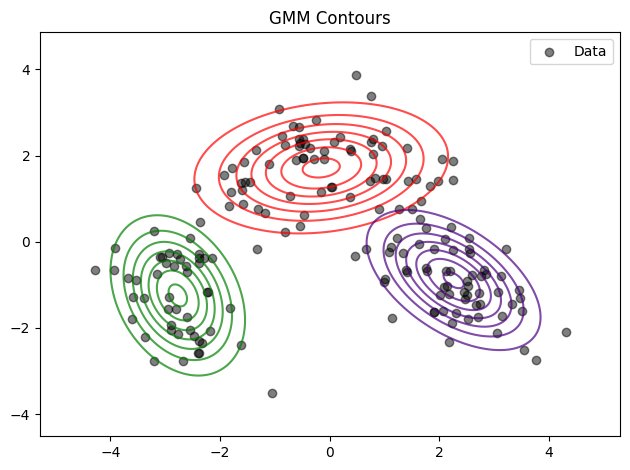

<Figure size 640x480 with 0 Axes>

GMM Silhouette Score: 0.5581473461293222
K-Means Silhouette Score: 0.5610505693103247


In [11]:
def plot_contours(data, means, covs, title):
    """visualize the Gaussian components over the data"""
    plt.figure()
    
    # Scatter plot of the data points
    plt.scatter(data[:, 0], data[:, 1], c='black', marker='o', label='Data', alpha=0.5)
    
    delta = 0.025
    k = means.shape[0]
    x = np.arange(np.min(data[:, 0]) - 1, np.max(data[:, 0]) + 1, delta)
    y = np.arange(np.min(data[:, 1]) - 1, np.max(data[:, 1]) + 1, delta)
    x_grid, y_grid = np.meshgrid(x, y)
    coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T

    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        z_grid = multivariate_normal(mean, cov).pdf(coordinates).reshape(x_grid.shape)
        plt.contour(x_grid, y_grid, z_grid, colors=col[i], label=f'Component {i + 1}', alpha=0.7)

    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

gmm = GMM(n_components=3)
gmm.fit(X_pca)
gmm_labels = gmm.predict()
wine_data = X_pca
# Fit K-Means
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans_labels = kmeans.fit_predict(X_pca)

# Compute silhouette scores
gmm_silhouette_score = silhouette_score(X_pca, gmm_labels)
kmeans_silhouette_score = silhouette_score(X_pca, kmeans_labels)

# Plot scatter plots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(wine_data[:, 0], wine_data[:, 1], c=gmm_labels, cmap='viridis')
plt.title('GMM Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.subplot(1, 2, 2)
plt.scatter(wine_data[:, 0], wine_data[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()
# Add contour plot for GMM
plot_contours(X_pca, gmm.means_, gmm.covariances_, 'GMM Contours')
plt.tight_layout()
plt.show()
# Print silhouette scores
print(f'GMM Silhouette Score: {gmm_silhouette_score}')
print(f'K-Means Silhouette Score: {kmeans_silhouette_score}')


/tmp/ipykernel_11671/4079326286.py:29: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(x_grid, y_grid, z_grid, colors=col[i], label=f'Component {i + 1}', alpha=0.7)


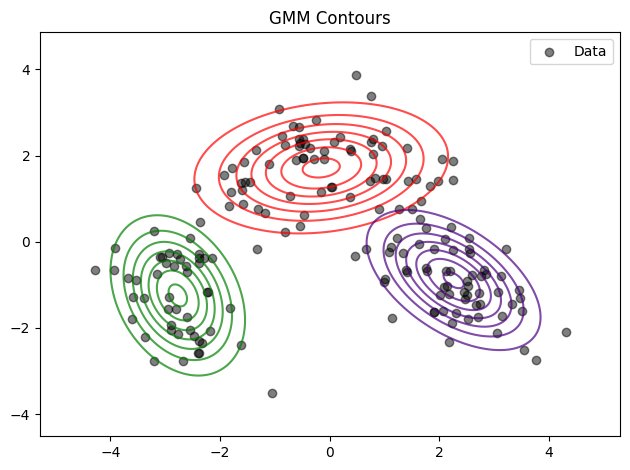

<Figure size 640x480 with 0 Axes>

In [10]:
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Define your GMM class here (as you've provided earlier)

# Corrected plot_contours function


